In [1]:
# Reload magic
%reload_ext autoreload
%autoreload 2

In [2]:
# Ignore user warnings
import warnings

import cellrank as cr
import jax
import matplotlib.pyplot as plt
import numpy as np
import optax
import orbax
import scanpy as sc

import spacetime
from spacetime import potentials, steps

warnings.filterwarnings("ignore")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Create data

In [3]:
adata = sc.read_h5ad(
    "/export/home1/users/csb/huizing/Documents/PhD/Data/dorsal_midbrain/dorsal_midbrain_processed.h5ad"
)
adata

AnnData object with n_obs × n_vars = 13969 × 10000
    obs: 'CellID', 'Batch', 'annotation', 'S_score', 'G2M_score', 'phase', 'Time point', 'n_genes', 'time'
    var: 'Gene', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable'
    uns: 'FP200000600TR_E3', 'SS200000108BR_A3A4', 'SS200000108BR_B1B2', 'SS200000131BL_C3C4', 'SS200000131BL_C5C6', 'angle_dict', 'annotation_colors', 'hvg', 'neighbors', 'pca', 'pearson_residuals_normalization', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
sc.pp.neighbors(adata, use_rep="X_pca_harmony")

In [5]:
adata.obsm["X_pca_harmony"] = adata.obsm["X_pca_harmony"][:, :5]
adata.obsm["X_pca_harmony"] /= adata.obsm["X_pca_harmony"].max()

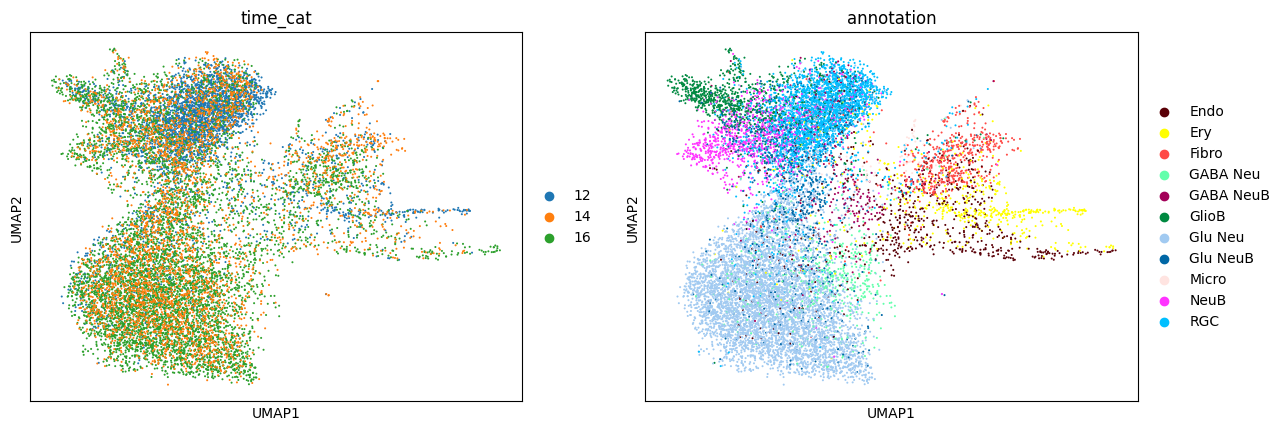

In [6]:
adata.obs["time_cat"] = adata.obs["time"].astype("category")
sc.pl.umap(adata, color=["time_cat", "annotation"])

## Train model

In [7]:
from flax.linen.activation import gelu

In [8]:
# Define the potential.
potential = potentials.MLPPotential(features=[128, 128], activation=gelu)

# Define the proximal step.
proximal_step = steps.LinearExplicitStep()
# proximal_step = steps.ICNNLinearImplicitStep()

# Define the model.
model = spacetime.SpaceTime(
    potential=potential,
    proximal_step=proximal_step,
    epsilon=0.01,
    # teacher_forcing=False,
)

In [9]:
!rm -r /tmp/midbrain

In [10]:
# Define the checkpoint manager.
options = orbax.checkpoint.CheckpointManagerOptions(
    save_interval_steps=1,
    max_to_keep=1,
    best_fn=lambda x: x["loss"],
    best_mode="min",
)
checkpoint_manager = orbax.checkpoint.CheckpointManager(
    "/tmp/midbrain/checkpoints",
    orbax.checkpoint.PyTreeCheckpointer(),
    options=options,
)
for step in checkpoint_manager.all_steps():
    checkpoint_manager.delete(step)

# Define the scheduler.
lr = optax.constant_schedule(1e-2)

# Fit the model.
model.fit(
    adata,
    time_obs="time",
    x_obsm="X_pca_harmony",
    space_obsm="spatial",
    batch_size=250,
    patience=50,
    optimizer=optax.adamw(lr),
    min_delta=1e-4,
    checkpoint_manager=checkpoint_manager,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

Train (# cells):  [2936, 2918, 5320]
Val (# cells):  [735, 730, 1330]


  8%|▊         | 795/10000 [01:52<21:37,  7.10it/s, iteration=796, train_loss=0.0063831974, val_loss=0.0040697423]

Met early stopping criteria, breaking...


In [11]:
best_step = checkpoint_manager.best_step()
print("Restoring best step:", best_step)
model.params = checkpoint_manager.restore(best_step)
potential_fn = lambda x: model.potential.apply(model.params, x)
adata.obs["potential"] = np.array(jax.vmap(potential_fn)(adata.obsm["X_pca_harmony"]))

Restoring best step: 568


## Display the predictions

In [12]:
adata.obs["time"] = adata.obs["time"].astype(int)

In [13]:
adata.obsm["X_pred"] = adata.obsm["X_pca_harmony"].copy()

for i, t in enumerate(np.unique(adata.obs["time"])):
    idx = adata.obs["time"] == t
    adata.obsm["X_pred"][idx] = model.transform(adata[idx], x_obsm="X_pca_harmony")

In [14]:
potential_fn = lambda x: model.potential.apply(model.params, x)
adata.obs["potential"] = np.array(jax.vmap(potential_fn)(adata.obsm["X_pca_harmony"]))

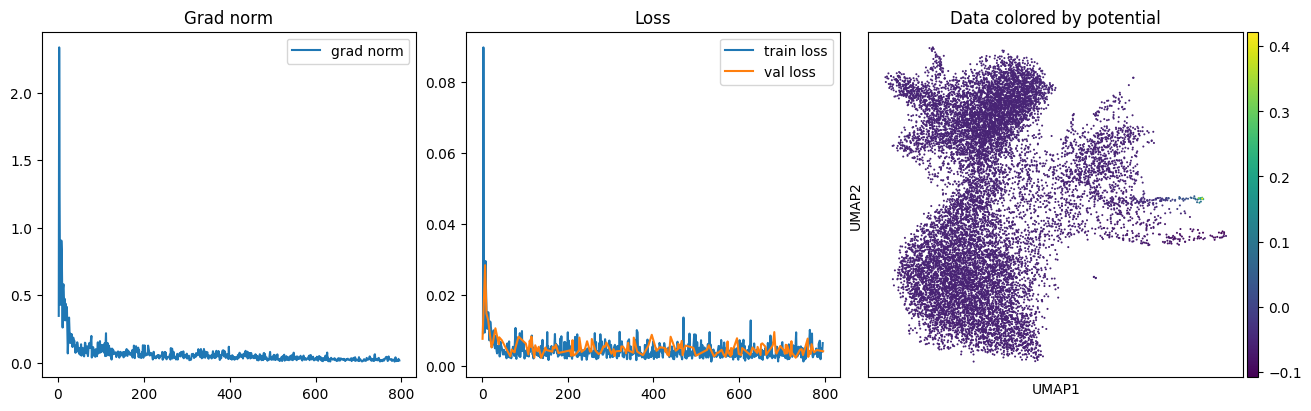

In [15]:
# Plot the data, with a legend for the timepoints, color with Reds.
fig, axes = plt.subplots(1, 3, figsize=(13, 4), constrained_layout=True)

axes[0].plot(model.train_it, model.grad_norms, label="grad norm")
axes[0].set_title("Grad norm")
axes[0].legend()

axes[1].plot(model.train_it, model.train_losses, label="train loss")
axes[1].plot(model.val_it, model.val_losses, label="val loss")
axes[1].set_title("Loss")
axes[1].legend()

# Plot the data colored by potential
sc.pl.umap(adata, color="potential", ax=axes[2], show=False)
# Legend with larger dots.
axes[2].set_title("Data colored by potential")
plt.show()

In [16]:
timepoints = np.sort(adata.obs["time"].unique())

In [17]:
from scipy.spatial.distance import cdist

In [18]:
# Ignore warnings
import warnings

warnings.filterwarnings("ignore")

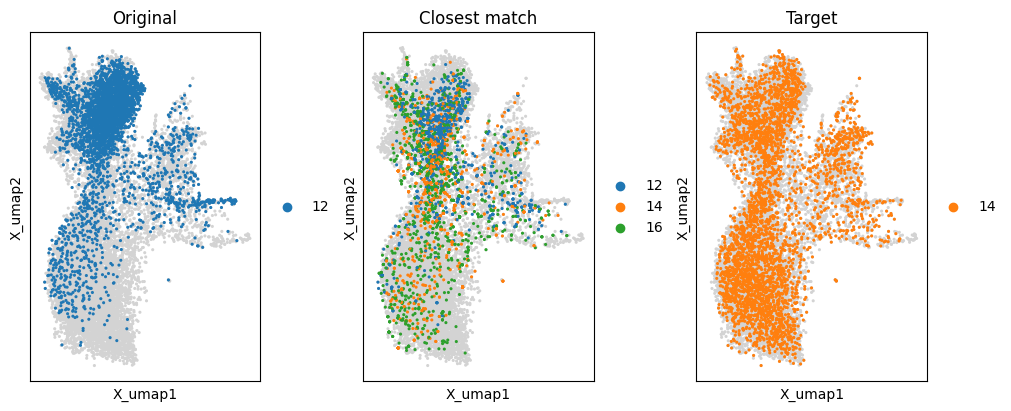

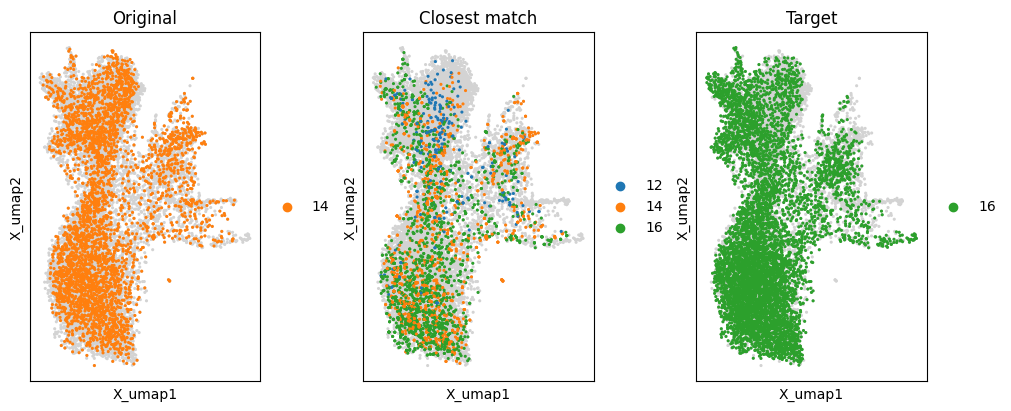

In [19]:
for i, t in enumerate(timepoints[:-1]):
    idx_left = adata.obs["time"].astype(int) == t
    D = cdist(adata.obsm["X_pred"][idx_left], adata.obsm["X_pca_harmony"])
    idx_right = D.argmin(1)
    idx_target = adata.obs["time"].astype(int) == timepoints[i + 1]
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)
    sc.pl.embedding(adata, basis="X_umap", s=20, ax=axes[0], show=False)
    sc.pl.embedding(
        adata[idx_left], basis="X_umap", s=20, ax=axes[0], color="time_cat", show=False
    )
    sc.pl.embedding(adata, basis="X_umap", s=20, ax=axes[1], show=False)
    sc.pl.embedding(
        adata[idx_right], basis="X_umap", s=20, ax=axes[1], color="time_cat", show=False
    )
    sc.pl.embedding(adata, basis="X_umap", s=20, ax=axes[2], show=False)
    sc.pl.embedding(
        adata[idx_target],
        basis="X_umap",
        s=20,
        ax=axes[2],
        color="time_cat",
        show=False,
    )
    axes[0].set_title("Original")
    axes[1].set_title("Closest match")
    axes[2].set_title("Target")
    plt.show()

  0%|          | 0/13969 [00:00<?, ?cell/s]

  0%|          | 0/13969 [00:00<?, ?cell/s]

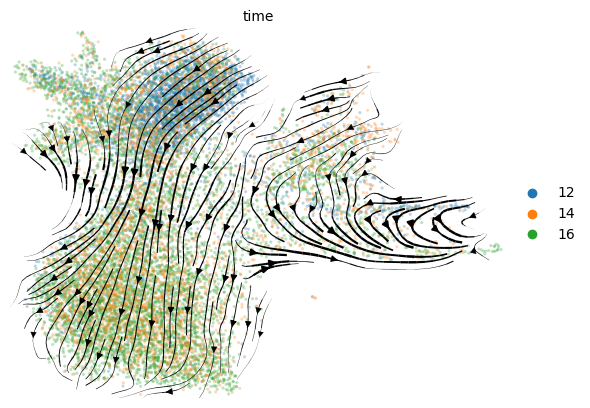

In [20]:
adata.obsm["X_velocity"] = adata.obsm["X_pred"] - adata.obsm["X_pca_harmony"]
vk = cr.kernels.VelocityKernel(
    adata, xkey="X_pca_harmony", vkey="X_velocity", attr="obsm"
)
vk.compute_transition_matrix()
vk.plot_projection(basis="umap", recompute=True, color="time", legend_loc="right", s=20)